In [1]:
import seisbench
import seisbench.models as sbm

from matplotlib import pyplot as plt, patches
from obspy.taup import TauPyModel
import numpy as np
import obspy

/opt/anaconda3/envs/phasedeal/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
provider = "IRIS" 
year = 2018
evt_check = "20181128101709090000"
data_sac = f'/media/tianjue/Data/SEAsia/Auto_PickP/Use/Download/{provider}/SAC/{year}'
data_dir = f'{data_sac}/{evt_check}'

In [4]:
### request the pre-determined model
pn0_model = sbm.PhaseNet.from_pretrained("neic")      ### Mainly global data with some regional data
pn1_model = sbm.PhaseNet.from_pretrained("scedc")     ### local and regional data
eqt_model = sbm.EQTransformer.from_pretrained("geofon")  ### Mainly global data with some regional data

In [5]:
### use GPU to load model
pn0_model.cuda()
pn1_model.cuda()
eqt_model.cuda()

EQTransformer(
  (encoder): Encoder(
    (convs): ModuleList(
      (0): Conv1d(3, 8, kernel_size=(11,), stride=(1,), padding=(5,))
      (1): Conv1d(8, 16, kernel_size=(9,), stride=(1,), padding=(4,))
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(1,), padding=(3,))
      (3): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=(3,))
      (4): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (5): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (pools): ModuleList(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1,

3 Trace(s) in Stream:
II.KURK.00.BHE | 2018-11-28T10:17:09.119538Z - 2018-11-28T11:17:09.069538Z | 20.0 Hz, 72000 samples
II.KURK.00.BHN | 2018-11-28T10:17:09.119538Z - 2018-11-28T11:17:09.069538Z | 20.0 Hz, 72000 samples
II.KURK.00.BHZ | 2018-11-28T10:17:09.119538Z - 2018-11-28T11:17:09.069538Z | 20.0 Hz, 72000 samples


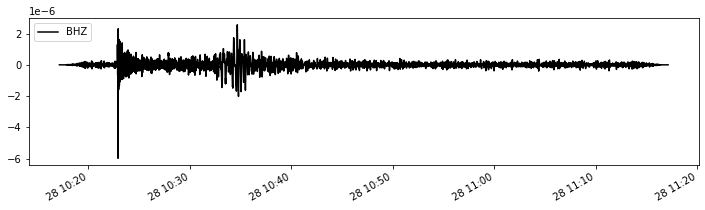

In [7]:
### prepare the seismic data, extract the info from file snr.info
net = "II"
sta = "KURK"
loc = "00"
channel = "BHZ"
# read the Z-component 3 times, cause ML method reads in 3-components data
st = obspy.read(f"{data_dir}/{net}.{sta}.{loc}.{channel}.SAC.bp")
tr = st.copy()
tr += obspy.read(f"{data_dir}/{net}.{sta}.{loc}.{channel}.SAC.bp")
tr += obspy.read(f"{data_dir}/{net}.{sta}.{loc}.{channel}.SAC.bp")
tr[0].stats.channel="BHE"
tr[1].stats.channel="BHN"
print(tr)

### visualize the seismic data
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot()
ax.plot(st[0].times("matplotlib"), st[0].data, color="black", label=st[0].stats.channel)
ax.xaxis_date()
ax.legend(loc ="upper left")

fig.autofmt_xdate()
plt.show()

In [8]:
model = TauPyModel(model="iasp91")

gcarc = st[0].stats.sac.gcarc
evdp = st[0].stats.sac.evdp

arrivals = model.get_travel_times(source_depth_in_km=evdp,
                        distance_in_degree=gcarc, phase_list=["ttp"])

tp_iasp91 = arrivals[0].time
print("Tp = {:.2f}s".format(tp_iasp91))

Tp = 342.27s


In [9]:
### apply the ML methods on real data
pn0_preds = pn0_model.annotate(tr)
pn1_preds = pn1_model.annotate(tr)
eqt_preds = eqt_model.annotate(tr)

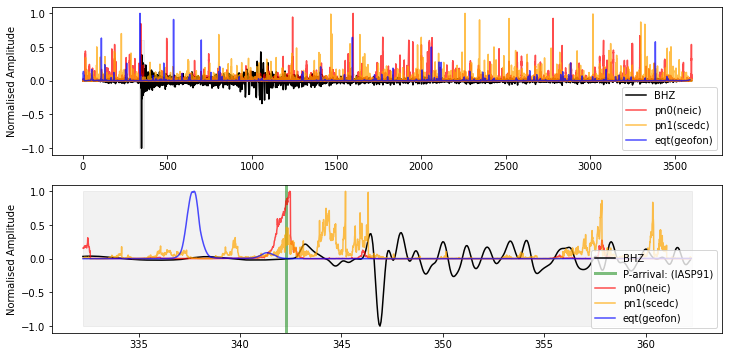

In [10]:
wlength = tr[2].stats.sac.npts

for s in range(0, int(tr[2].stats.endtime - tr[2].stats.starttime), wlength):
    t0 = tr[2].stats.starttime + s
    t1 = t0 + wlength
    subst = tr.slice(t0, t1)

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(211)
ax1.plot(subst[-1].times(), subst[-1].data / np.amax(abs(subst[-1].data)), 'k', label=subst[-1].stats.channel)
ax1.set_ylabel('Normalised Amplitude')

subpreds = pn0_preds.slice(t0, t1)
for pred_trace in subpreds:
    model, pred_class = pred_trace.stats.channel.split("_")
    if pred_class == "P":
        ax1.plot(pred_trace.times(), pred_trace.data/max(pred_trace.data), label="pn0(neic)", color="red", alpha=0.7)

subpreds = pn1_preds.slice(t0, t1)
for pred_trace in subpreds:
    model, pred_class = pred_trace.stats.channel.split("_")
    if pred_class == "P":
        ax1.plot(pred_trace.times(), pred_trace.data/max(pred_trace.data), label="pn1(scedc)", color="orange", alpha=0.7)

subpreds = eqt_preds.slice(t0, t1)
for pred_trace in subpreds:
    model, pred_class = pred_trace.stats.channel.split("_")
    if pred_class == "P":
        ax1.plot(pred_trace.times(), pred_trace.data/max(pred_trace.data), label="eqt(geofon)", color="blue", alpha=0.7)

ax1.legend(loc="lower right")
rect = patches.Rectangle((tp_iasp91-10, -1), 30, 1.6*1.0, color='gray',alpha=0.1)
ax1.add_patch(rect)
ax1.legend(loc="lower right")

ax2 = fig.add_subplot(212)
idxs1 = int((tp_iasp91-10)/st[0].stats.delta)
idxs2 = int((tp_iasp91+20)/st[0].stats.delta)
ax2.plot(subst[-1].times()[idxs1:idxs2], subst[-1].data[idxs1:idxs2] / np.amax(abs(subst[-1].data[idxs1:idxs2])), 'k', label=subst[-1].stats.channel)
ax2.axvline(x=tp_iasp91,color="green",linewidth=3,alpha=0.5,label="P-arrival: (IASP91)")
ax2.set_ylabel('Normalised Amplitude')

subpreds = pn0_preds.slice(t0, t1)
for pred_trace in subpreds:
    model, pred_class = pred_trace.stats.channel.split("_")
    if pred_class == "P":
        idxt1 = int((tp_iasp91-10)/pred_trace.stats.delta)
        idxt2 = int((tp_iasp91+20)/pred_trace.stats.delta)
        ax2.plot(pred_trace.times()[idxt1:idxt2], pred_trace.data[idxt1:idxt2]/max(pred_trace.data[idxt1:idxt2]), label="pn0(neic)", color="red", alpha=0.7)

subpreds = pn1_preds.slice(t0, t1)
for pred_trace in subpreds:
    model, pred_class = pred_trace.stats.channel.split("_")
    if pred_class == "P":
        idxt1 = int((tp_iasp91-10)/pred_trace.stats.delta)
        idxt2 = int((tp_iasp91+20)/pred_trace.stats.delta)
        ax2.plot(pred_trace.times()[idxt1:idxt2], pred_trace.data[idxt1:idxt2]/max(pred_trace.data[idxt1:idxt2]), label="pn1(scedc)", color="orange", alpha=0.7)

subpreds = eqt_preds.slice(t0, t1)
for pred_trace in subpreds:
    model, pred_class = pred_trace.stats.channel.split("_")
    if pred_class == "P":
        idxt1 = int((tp_iasp91-10)/pred_trace.stats.delta)
        idxt2 = int((tp_iasp91+20)/pred_trace.stats.delta)
        ax2.plot(pred_trace.times()[idxt1:idxt2], pred_trace.data[idxt1:idxt2]/max(pred_trace.data[idxt1:idxt2]), label="eqt(geofon)", color="blue", alpha=0.7)

rect = patches.Rectangle((tp_iasp91-10, -1), 30, 2.0*1.0, color='gray',alpha=0.1)
ax2.add_patch(rect)
ax2.legend(loc="lower right")

plt.show()